In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #30x30
        x = self.pool(F.relu(self.conv2(x))) #14x14
        x = F.relu(self.conv3(x)) #12x12
        x = self.pool(F.relu(self.conv4(x))) #5x5
        x = x.view(-1, 5*5*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [12]:
import torch.optim as optim
import time
import os
import shutil
from torch.utils.tensorboard import SummaryWriter
NET_PATH = './cifar_net.pth'

# default `log_dir` is "runs" - we'll be more specific here



def train(device):
    path = './runs/CIFAR10'
    try:
        shutil.rmtree(path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))
    if os.path.exists(NET_PATH):
        os.remove(NET_PATH)
    writer = SummaryWriter(path)
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    start = time.time()
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            if i % 1000 == 999:
                writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)    

    end = time.time()
    print("train time on device: "+ device +" "+ str(end - start))
    print('Finished Training')
   
    torch.save(net.state_dict(), NET_PATH)

In [13]:
def test(device):
    net = Net().to(device)
    net.load_state_dict(torch.load(NET_PATH))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))    

In [136]:
def testNew(device):
    net = Net().to(device)
    net.load_state_dict(torch.load(NET_PATH))
    correct = 0
    total = 0
    wrongLabels = []
    wrongImages = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            values, indices = torch.topk(outputs.data, 3)
            _, predicted = torch.max(indices.data, 1)
            total += labels.size(0)
            for i in range(4):
                if labels[i] in indices[i]:
                     correct += 1
                else:
                    wrongLabels.append(labels[i])
                    wrongImages.append(images[i])
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))   
    return wrongLabels, wrongImages 

In [8]:
train("cpu")

[1,  2000] loss: 2.290
[1,  4000] loss: 1.990
[1,  6000] loss: 1.745
[1,  8000] loss: 1.644
[1, 10000] loss: 1.544
[1, 12000] loss: 1.484
[2,  2000] loss: 1.380
[2,  4000] loss: 1.295
[2,  6000] loss: 1.250
[2,  8000] loss: 1.223
[2, 10000] loss: 1.181
[2, 12000] loss: 1.134
train time on device: cpu 873.1741876602173
Finished Training


In [14]:
train("cuda:0" if torch.cuda.is_available() else "cpu")

[1,  2000] loss: 2.302
[1,  4000] loss: 2.141
[1,  6000] loss: 1.926
[1,  8000] loss: 1.724
[1, 10000] loss: 1.603
[1, 12000] loss: 1.529
[2,  2000] loss: 1.412
[2,  4000] loss: 1.340
[2,  6000] loss: 1.286
[2,  8000] loss: 1.235
[2, 10000] loss: 1.176
[2, 12000] loss: 1.144
train time on device: cuda:0 147.24747943878174
Finished Training


In [15]:
test("cuda:0" if torch.cuda.is_available() else "cpu")

Accuracy of the network on the 10000 test images: 62 %


In [137]:
result = testNew("cuda:0" if torch.cuda.is_available() else "cpu")

da:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(9, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(8, device='cuda:0'), tensor(4, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(4, device='cuda:0'), tensor(7, device='cuda:0'), tensor(1, device='cuda:0'), tensor(8, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(4, device='cuda:0'), tensor(6, device='cuda:0'), tensor(6, device='cuda:0'), tensor(1, device='cuda:0'), tensor(4, device='cuda:0'), tensor(5, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(8, device='cuda:0'), tensor(3, device='cuda:0'), tensor(8, device='cuda:0'), tensor(5, device='cuda:0'), tensor(6, device='cuda:0'), tensor(2, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, de

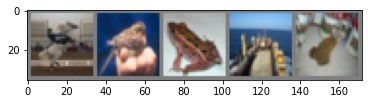

  dog  frog  deer truck plane


In [140]:
import matplotlib.pyplot as plt
import numpy as np
import random

# functions to show an image


def imshow(img):
    img = img.cpu()
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(random.sample(result[1], 5)))
print(' '.join('%5s' % classes[result[0][j]] for j in range(5)))